# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt

# NLP
import nltk
nltk.download(['stopwords','punkt', 'wordnet'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Scikit-Learn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/RobertSmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/RobertSmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/RobertSmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# load data from database
engine = create_engine('sqlite:///../data/disaster_response.db')
df = pd.read_sql("SELECT * FROM messages;", con = engine)
X = df["message"]
cols_to_keep = [col for col in df.columns[4:] if (df[col].sum() > 0)]
Y = df[cols_to_keep]

### 2. Write a tokenization function to process your text data
Tokenization steps:
1. normalize
2. remove punctuation
3. tokenize
4. remove stopwords
5. lemmatize


In [4]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^A-Za-z0-9]", " ",text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stopwords.words("english")]
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    return words

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
basic_pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer = tokenize)),
    ("tfidf", TfidfTransformer()),
    ("model", RandomForestClassifier(random_state=42))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [7]:
basic_model = basic_pipeline.fit(X_train, Y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [9]:
basic_preds = basic_model.predict(X_test)

In [12]:
print(classification_report(Y_test, basic_preds, target_names = Y_test.columns))

                        precision    recall  f1-score   support

               related       0.85      0.94      0.89      6012
               request       0.84      0.50      0.63      1313
                 offer       0.00      0.00      0.00        36
           aid_related       0.80      0.55      0.65      3255
          medical_help       0.70      0.02      0.04       629
      medical_products       0.79      0.04      0.07       406
     search_and_rescue       0.71      0.02      0.05       202
              security       0.00      0.00      0.00       151
              military       0.65      0.05      0.08       244
                 water       0.88      0.26      0.40       493
                  food       0.87      0.42      0.57       861
               shelter       0.81      0.20      0.33       715
              clothing       0.83      0.09      0.16       114
                 money       0.80      0.05      0.09       174
        missing_people       1.00      

In [16]:
f1_score(Y_test, basic_preds, pos_label=1, average = "micro")

0.5995815791512772

In [18]:
category_names = Y_test.columns
f1_scores = []
for i in range(0,len(category_names)):
    f1_scores.append(round(f1_score(Y_test.iloc[:,i], basic_preds[:,i], pos_label=1), 2))
f1_scores = pd.Series(f1_scores, index=category_names)

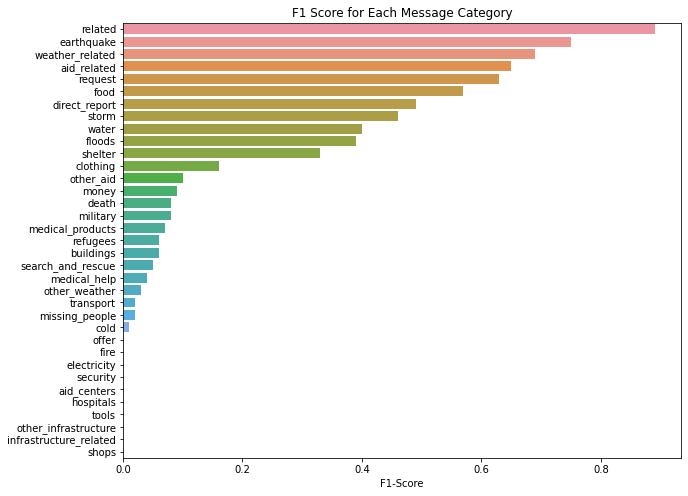

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=f1_scores.values,
            y=f1_scores.index,
            order=f1_scores.sort_values(ascending=False).index, 
            ax = ax)
ax.set_title("F1 Score for Each Message Category")
ax.set_xlabel("F1-Score");

In [13]:
basic_f1_scores = pd.Series(dtype = float)
for col in range(0,basic_preds.shape[1]):
    print(f"Classification Report for: {y_test.iloc[:,col].name}")
    print(classification_report(y_test.iloc[:,col], basic_preds[:,col]))
    basic_f1_scores = basic_f1_scores.append(pd.Series(round(f1_score(y_test.iloc[:,col], basic_preds[:,col], pos_label = 1),2)))
basic_f1_scores.index = y_test.columns
    

/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Classification Report for: medical_products
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7447
           1       0.73      0.03      0.05       418

    accuracy                           0.95      7865
   macro avg       0.84      0.51      0.51      7865
weighted avg       0.94      0.95      0.92      7865

Classification Report for: search_and_rescue
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7673
           1       0.86      0.03      0.06       192

    accuracy                           0.98      7865
   macro avg       0.92      0.52      0.52      7865
weighted avg       0.97      0.98      0.97      7865

Classification Report for: security
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7721
           1       0.00      0.00      0.00       144

    accuracy                           0.98      7865
   

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7127
           1       0.77      0.33      0.46       738

    accuracy                           0.93      7865
   macro avg       0.85      0.66      0.71      7865
weighted avg       0.92      0.93      0.91      7865

Classification Report for: fire
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7782
           1       0.00      0.00      0.00        83

    accuracy                           0.99      7865
   macro avg       0.49      0.50      0.50      7865
weighted avg       0.98      0.99      0.98      7865

Classification Report for: earthquake
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7163
           1       0.88      0.66      0.75       702

    accuracy                           0.96      7865
   macro avg       0.92      0.83      0.87      7865
weig

### 6. Improve your model
Use grid search to find better parameters. 

In [32]:
parameters = {
#    'vect__ngram_range': ((1, 1), (1, 2)),
#    'vect__max_features': [None,100],
    'tfidf__use_idf': (True, False),
    #'model__n_estimators': [200, 500],
    'model__min_samples_split': [4, 8]
    #'model__max_features': ["sqrt", "log2"]
}

cv = GridSearchCV(basic_pipeline, param_grid = parameters, verbose=3, cv=3, scoring = "f1_micro")

In [33]:
cv_basic_model = cv.fit(X_train, Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] model__min_samples_split=4, tfidf__use_idf=True .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__min_samples_split=4, tfidf__use_idf=True, score=0.594, total= 2.1min
[CV] model__min_samples_split=4, tfidf__use_idf=True .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  model__min_samples_split=4, tfidf__use_idf=True, score=0.600, total= 2.7min
[CV] model__min_samples_split=4, tfidf__use_idf=True .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min remaining:    0.0s


[CV]  model__min_samples_split=4, tfidf__use_idf=True, score=0.593, total= 2.5min
[CV] model__min_samples_split=4, tfidf__use_idf=False ................
[CV]  model__min_samples_split=4, tfidf__use_idf=False, score=0.595, total= 2.5min
[CV] model__min_samples_split=4, tfidf__use_idf=False ................
[CV]  model__min_samples_split=4, tfidf__use_idf=False, score=0.599, total= 2.4min
[CV] model__min_samples_split=4, tfidf__use_idf=False ................
[CV]  model__min_samples_split=4, tfidf__use_idf=False, score=0.597, total=37.0min
[CV] model__min_samples_split=8, tfidf__use_idf=True .................
[CV]  model__min_samples_split=8, tfidf__use_idf=True, score=0.595, total= 2.2min
[CV] model__min_samples_split=8, tfidf__use_idf=True .................
[CV]  model__min_samples_split=8, tfidf__use_idf=True, score=0.598, total= 2.2min
[CV] model__min_samples_split=8, tfidf__use_idf=True .................
[CV]  model__min_samples_split=8, tfidf__use_idf=True, score=0.594, total= 2.2m

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 64.2min finished


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [34]:
cv_basic_preds = cv_basic_model.predict(X_test)

In [35]:
print(classification_report(Y_test, cv_basic_preds, target_names = Y_test.columns))

                        precision    recall  f1-score   support

               related       0.85      0.95      0.89      6012
               request       0.83      0.50      0.63      1313
                 offer       0.00      0.00      0.00        36
           aid_related       0.80      0.56      0.66      3255
          medical_help       0.64      0.01      0.03       629
      medical_products       0.68      0.03      0.06       406
     search_and_rescue       0.71      0.02      0.05       202
              security       0.00      0.00      0.00       151
              military       0.57      0.03      0.06       244
                 water       0.86      0.25      0.39       493
                  food       0.87      0.47      0.61       861
               shelter       0.83      0.28      0.41       715
              clothing       0.83      0.09      0.16       114
                 money       0.78      0.04      0.08       174
        missing_people       1.00      

/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### Models to Consider
* Gradient Boosting Classifier
* Adaboost
* SGDClassifier

### Other Features
- GloveVectorizer

In [36]:
# source: https://faculty.ai/blog/glove/
%load_ext autoreload
%autoreload 2
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

class GloveVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="en_core_web_md"):
        self.model_name = model_name
        self._nlp = spacy.load(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.concatenate([self._nlp(doc).vector.reshape(1, -1) for doc in X])

## Gradient Boosting Classifier 

In [37]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [38]:
    tfidf_pipeline = Pipeline([
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer()),
        ('reduce_dim', TruncatedSVD())])

    glove_pipeline = Pipeline([
        ("glove", GloveVectorizer()),
        ("reduce_dim", TruncatedSVD())])

    pipeline = Pipeline([
        ("features", FeatureUnion([
            ("tfidf_pipeline", tfidf_pipeline),
            ("glove_pipeline", glove_pipeline)
        ])),
        ("model", MultiOutputClassifier(GradientBoostingClassifier(random_state=42)))
    ])

    parameters = {
        'features__tfidf_pipeline__reduce_dim__n_components': [100],
        'features__tfidf_pipeline__reduce_dim__random_state': [1234],
        'features__glove_pipeline__reduce_dim__random_state':[1234],
        'features__glove_pipeline__reduce_dim__n_components': [50],
        'model__estimator__max_depth': [10],
        'model__estimator__n_estimators': [100]
    }

In [ ]:
gbc_model_pipeline = GridSearchCV(pipeline,
                                  param_grid=parameters,
                                  verbose = 3,
                                  cv = 2,
                                  scoring = "f1_micro")

gbc_model_pipeline.fit(X_train, Y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] features__glove_pipeline__reduce_dim__n_components=50, features__glove_pipeline__reduce_dim__random_state=1234, features__tfidf_pipeline__reduce_dim__n_components=100, features__tfidf_pipeline__reduce_dim__random_state=1234, model__estimator__max_depth=10, model__estimator__n_estimators=100 
[CV]  features__glove_pipeline__reduce_dim__n_components=50, features__glove_pipeline__reduce_dim__random_state=1234, features__tfidf_pipeline__reduce_dim__n_components=100, features__tfidf_pipeline__reduce_dim__random_state=1234, model__estimator__max_depth=10, model__estimator__n_estimators=100, score=0.627, total=87.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 88.0min remaining:    0.0s


[CV] features__glove_pipeline__reduce_dim__n_components=50, features__glove_pipeline__reduce_dim__random_state=1234, features__tfidf_pipeline__reduce_dim__n_components=100, features__tfidf_pipeline__reduce_dim__random_state=1234, model__estimator__max_depth=10, model__estimator__n_estimators=100 
[CV]  features__glove_pipeline__reduce_dim__n_components=50, features__glove_pipeline__reduce_dim__random_state=1234, features__tfidf_pipeline__reduce_dim__n_components=100, features__tfidf_pipeline__reduce_dim__random_state=1234, model__estimator__max_depth=10, model__estimator__n_estimators=100, score=0.634, total=108.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 196.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 196.8min finished


In [43]:
gbc_preds = gbc_model_pipeline.predict(X_test)

In [96]:
print(classification_report(Y_test, gbc_preds, target_names = Y_test.columns))

/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
category_names = Y_test.columns
f1_scores = []
for i in range(0,len(category_names)):
    f1_scores.append(round(f1_score(Y_test.iloc[:,i], gbc_preds[:,i], pos_label=1), 2))
f1_scores = pd.Series(f1_scores, index=category_names)

Classification Report for: medical_products
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7447
           1       0.57      0.15      0.24       418

    accuracy                           0.95      7865
   macro avg       0.76      0.57      0.61      7865
weighted avg       0.93      0.95      0.93      7865

Classification Report for: search_and_rescue
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7673
           1       0.18      0.02      0.04       192

    accuracy                           0.97      7865
   macro avg       0.58      0.51      0.51      7865
weighted avg       0.96      0.97      0.96      7865

Classification Report for: security
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7721
           1       0.05      0.01      0.02       144

    accuracy                           0.98      7865
   

Classification Report for: storm
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7127
           1       0.72      0.41      0.53       738

    accuracy                           0.93      7865
   macro avg       0.83      0.70      0.74      7865
weighted avg       0.92      0.93      0.92      7865

Classification Report for: fire
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7782
           1       0.03      0.01      0.02        83

    accuracy                           0.99      7865
   macro avg       0.51      0.50      0.50      7865
weighted avg       0.98      0.99      0.98      7865

Classification Report for: earthquake
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7163
           1       0.87      0.70      0.78       702

    accuracy                           0.96      7865
   macro avg       0.92  

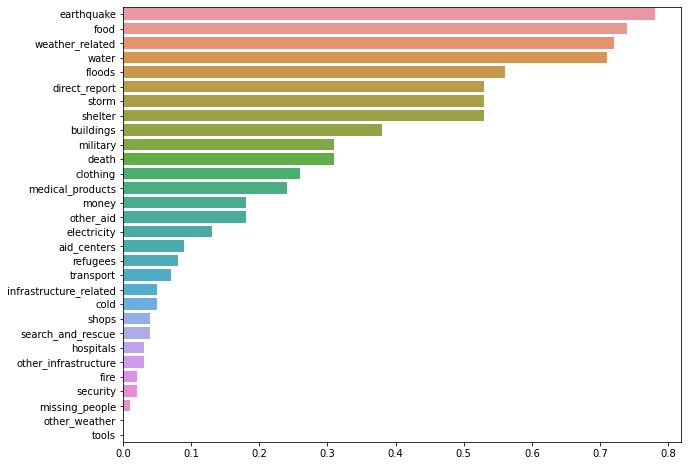

In [98]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.barplot(x = f1_scores, 
            y = f1_scores.index, 
            order = f1_scores.sort_values(ascending=False).index);

## Adaboost Classifier

In [ ]:
parameters = {
    'features__tfidf_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
    'features__tfidf_pipeline__vect__max_df': (0.5, 0.75, 1.0),
    'features__tfidf_pipeline__vect__max_features': (None, 5000, 10000),
    'features__tfidf_pipeline__tfidf__use_idf': (True, False),
    'model__estimator__n_estimators': [50, 100, 200],
    'model__estimator__min_samples_split': [2, 3, 4]
}

cv = GridSearchCV(pipeline, param_grid = parameters, n_jobs = -1)

In [ ]:
cv_model = cv.fit(X_train, y_train)

In [11]:
model = AdaBoostClassifier(random_state=42)

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, max_df = 0.75)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(model))
])

parameters = {'clf__estimator__n_estimators': [20],
              'clf__estimator__learning_rate': [1.2]}


cv = GridSearchCV(pipeline, cv=3, param_grid=parameters, scoring='f1_micro', 
                  verbose=2)


cv.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__estimator__learning_rate=1.2, clf__estimator__n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__learning_rate=1.2, clf__estimator__n_estimators=20, total= 2.1min
[CV] clf__estimator__learning_rate=1.2, clf__estimator__n_estimators=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  clf__estimator__learning_rate=1.2, clf__estimator__n_estimators=20, total= 2.2min
[CV] clf__estimator__learning_rate=1.2, clf__estimator__n_estimators=20 
[CV]  clf__estimator__learning_rate=1.2, clf__estimator__n_estimators=20, total= 2.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_df=0.75,
                                                        tokenizer=<function tokenize at 0x109845670>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier(random_state=42)))]),
             param_grid={'clf__estimator__learning_rate': [1.2],
                         'clf__estimator__n_estimators': [20]},
             scoring='f1_macro', verbose=2)

In [12]:
test_preds = cv.predict(X_test)

In [14]:
performance_report = classification_report(Y_test, test_preds, target_names = Y_test.columns)

/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/RobertSmith/PycharmProjects/disaster-response-pipeline/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print(performance_report)

                        precision    recall  f1-score   support

               related       0.79      0.98      0.87      6012
               request       0.74      0.50      0.60      1313
                 offer       0.12      0.03      0.05        36
           aid_related       0.71      0.58      0.64      3255
          medical_help       0.56      0.24      0.33       629
      medical_products       0.65      0.25      0.36       406
     search_and_rescue       0.63      0.20      0.30       202
              security       0.22      0.03      0.06       151
              military       0.47      0.26      0.34       244
                 water       0.74      0.61      0.67       493
                  food       0.82      0.78      0.80       861
               shelter       0.75      0.52      0.62       715
              clothing       0.63      0.32      0.42       114
                 money       0.48      0.34      0.40       174
        missing_people       0.64      

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.